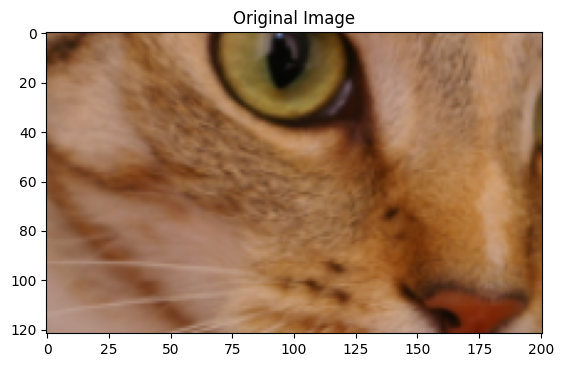

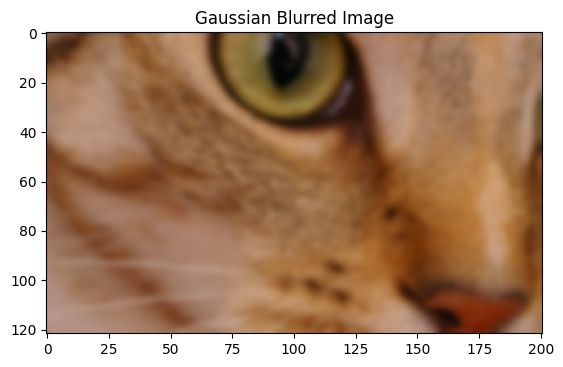

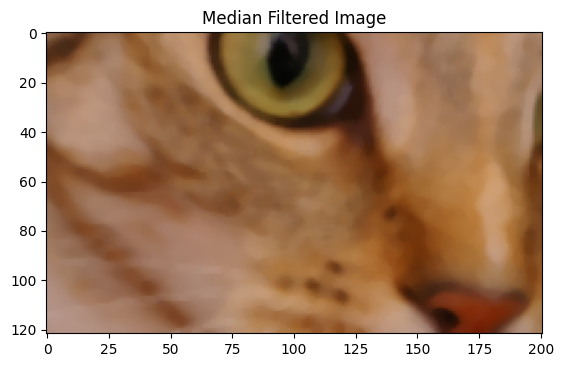

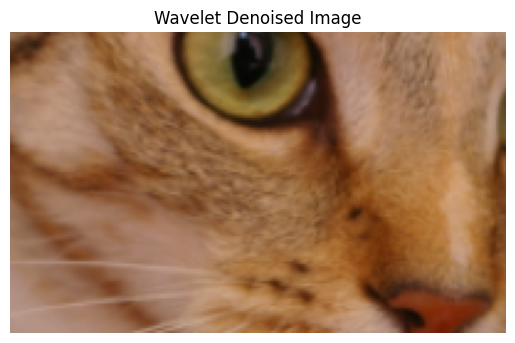

Gaussian Blur:
PSNR: 37.53, SSIM: 0.9964, MSE: 0.000177

Median Filter:
PSNR: 35.21, SSIM: 0.9941, MSE: 0.000301

Wavelet Denoising:
PSNR: 67.63, SSIM: 1.0000, MSE: 0.000000



In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import cv2
from skimage import io, restoration, metrics
from matplotlib import pyplot as plt

def load_image(path):
    image = io.imread(path)
    image = image.astype('float32') / 255.0  # Normalizing the image to [0, 1]
    return image

# Assuming 'image_path' is the path to your TIFF image
image_path = '/content/denoise1.png'
original_image = load_image(image_path)

plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.show()

# Gaussian blur denoising
gaussian_blur = cv2.GaussianBlur(original_image, (5, 5), 0)

plt.imshow(gaussian_blur, cmap='gray')
plt.title('Gaussian Blurred Image')
plt.show()

# Median filtering
median_filtered = cv2.medianBlur((original_image * 255).astype(np.uint8), 5)

plt.imshow(median_filtered, cmap='gray')
plt.title('Median Filtered Image')
plt.show()

# Wavelet denoising
# Fix for grayscale wavelet denoising
wavelet_denoised = restoration.denoise_wavelet(
    original_image,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
    channel_axis=None  # explicitly declare it's grayscale
)

plt.imshow(wavelet_denoised, cmap='gray')
plt.title('Wavelet Denoised Image')
plt.axis('off')
plt.show()


# ===================== Evaluation Metrics =====================

def evaluate(original, denoised, name):
    psnr = metrics.peak_signal_noise_ratio(original, denoised, data_range=1.0)
    ssim = metrics.structural_similarity(original, denoised, data_range=1.0, win_size=3, channel_axis=None)
    mse = metrics.mean_squared_error(original, denoised)
    print(f"{name}:\nPSNR: {psnr:.2f}, SSIM: {ssim:.4f}, MSE: {mse:.6f}\n")

# Convert median filtered image back to float32 in [0,1] range for evaluation
median_filtered_norm = median_filtered.astype('float32') / 255.0

# Evaluate all methods
evaluate(original_image, gaussian_blur, 'Gaussian Blur')
evaluate(original_image, median_filtered_norm, 'Median Filter')
evaluate(original_image, wavelet_denoised, 'Wavelet Denoising')



In [3]:
import cv2
import os

def extract_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        success, frame = cap.read()
        if not success:
            break
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"✅ Extracted {frame_count} frames to '{output_folder}'")

if __name__ == '__main__':
    # 👇 Replace this with the path to your .mp4 file
    video_path = "/content/video2.mp4"

    output_folder = "extracted_frames"
    extract_frames(video_path, output_folder)

✅ Extracted 121 frames to 'extracted_frames'


🔸 Median Filter (MSE, PSNR, SSIM): (np.float64(3.9216651916503906), np.float64(42.19609847422294), np.float64(0.9765967497450061))
🔸 Wavelet Filter (MSE, PSNR, SSIM): (np.float64(16256.655197143555), np.float64(6.020491664027537), np.float64(0.7484105349522681))


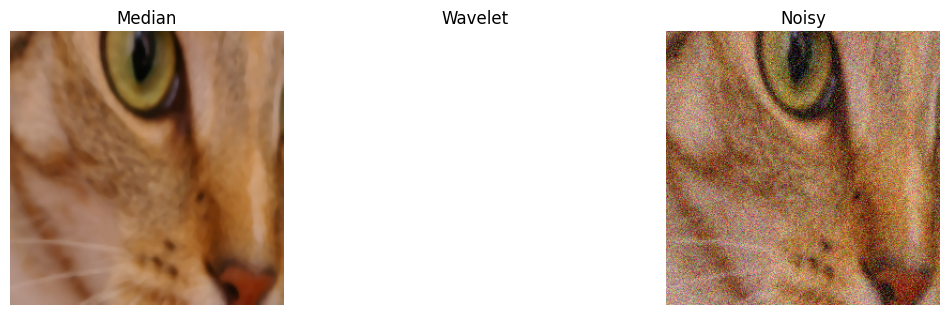

✅ Extracted 121 frames from video.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

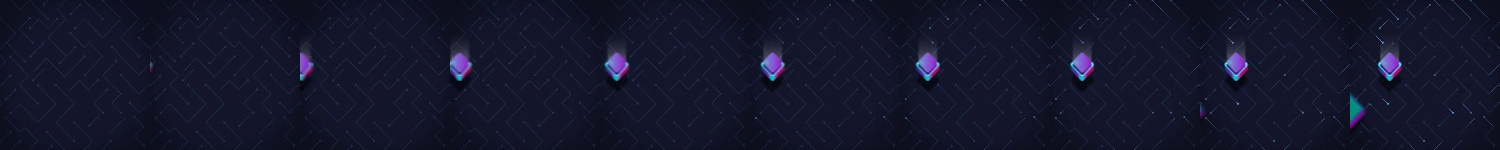

In [6]:
# Imports
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import img_as_float, restoration, metrics
from skimage.restoration import denoise_wavelet
from skimage.util import random_noise
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Paths to pre-uploaded files in Colab
image_path = "/content/denoise1.png"  # ⬅ Replace with your actual image path
video_path = "/content/video2.mp4"  # ⬅ Replace with your actual video path

# Folder setup
os.makedirs("frames", exist_ok=True)
os.makedirs("processed_frames", exist_ok=True)
os.makedirs("collage", exist_ok=True)

# ========================================
# 🔹 PART 1: IMAGE DENOISING
# ========================================

def apply_denoising_filters(img):
    median_filtered = cv2.medianBlur(img, 5)
    wavelet_filtered = denoise_wavelet(img_as_float(img), channel_axis=-1)
    wavelet_filtered = (wavelet_filtered * 255).astype(np.uint8)
    noisy = random_noise(img, var=0.01)
    noisy = (noisy * 255).astype(np.uint8)
    return median_filtered, wavelet_filtered, noisy

def compute_metrics(original, denoised):
    mse = metrics.mean_squared_error(original, denoised)
    psnr = metrics.peak_signal_noise_ratio(original, denoised)
    ssim = metrics.structural_similarity(original, denoised, channel_axis=-1)
    return mse, psnr, ssim

# Load image
img = imread(image_path)
img = resize(img, (256, 256), anti_aliasing=True)
img = (img * 255).astype(np.uint8)

# Apply filters
median, wavelet, noisy = apply_denoising_filters(img)

# Print metrics
print("🔸 Median Filter (MSE, PSNR, SSIM):", compute_metrics(img, median))
print("🔸 Wavelet Filter (MSE, PSNR, SSIM):", compute_metrics(img, wavelet))

# Visualize results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(median); plt.title("Median"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(wavelet); plt.title("Wavelet"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(noisy); plt.title("Noisy"); plt.axis('off')
plt.show()

# ========================================
# 🔹 PART 2: EXTRACT FRAMES FROM VIDEO
# ========================================

cap = cv2.VideoCapture(video_path)
i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f"frames/frame_{i:04d}.jpg", frame)
    i += 1
cap.release()
print(f"✅ Extracted {i} frames from video.")

# ========================================
# 🔹 PART 3: PROCESS FRAMES
# ========================================

frame_files = sorted(os.listdir("frames"))
for fname in frame_files:
    frame = cv2.imread(os.path.join("frames", fname))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    adaptive_thresh = cv2.adaptiveThreshold(gray, 255,
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(gray, 100, 200)
    bitwise_not = cv2.bitwise_not(gray)

    collage = np.hstack([adaptive_thresh, blurred, edges, bitwise_not])
    cv2.imwrite(f"processed_frames/{fname}", collage)

# ========================================
# 🔹 PART 4: RECREATE VIDEO & COLLAGE
# ========================================

import glob
import shutil

# Rebuild the list of processed frame paths
frame_paths = sorted(glob.glob("processed_frames/*.jpg"))

# Use ffmpeg to generate video from processed frames
!rm -rf video_frames && mkdir video_frames

# Copy frames to temp folder with renamed order
for idx, path in enumerate(frame_paths):
    new_name = f"video_frames/frame_{idx:04d}.jpg"
    shutil.copy(path, new_name)

# Use ffmpeg to compile into video
!ffmpeg -y -framerate 20 -i video_frames/frame_%04d.jpg -c:v libx264 -pix_fmt yuv420p processed_video.mp4

# Confirm video size
if os.path.exists("processed_video.mp4") and os.path.getsize("processed_video.mp4") > 0:
    print("✅ Video created using ffmpeg: processed_video.mp4")
    from google.colab import files
    files.download("processed_video.mp4")
else:
    print("❌ ffmpeg video creation failed.")





# Make collage from first 10 frames
collage = []
for fname in frame_files[:10]:
    img = cv2.imread(os.path.join("frames", fname))
    img = cv2.resize(img, (150, 150))
    collage.append(img)

collage_img = np.hstack(collage)
cv2.imwrite("collage/collage.jpg", collage_img)

# Show collage
Image.open("collage/collage.jpg")

In [ ]:
import kagglehub
import os
import shutil
import random

# Step 1: Download dataset
dataset_path = kagglehub.dataset_download("pevogam/ucf101")
print("✅ Dataset downloaded at:", dataset_path)


In [ ]:
import os
import shutil
import random

# Corrected path
SOURCE_DIR = "/root/.cache/kagglehub/datasets/pevogam/ucf101/versions/1/UCF101/UCF-101"
DEST_DIR = "./UCF101_subset"
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    # Get list of all .avi files
    videos = [f for f in os.listdir(class_path) if f.endswith('.avi')]
    selected = random.sample(videos, VIDEOS_PER_CLASS)

    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)

print("✅ Subset created at:", DEST_DIR)


In [ ]:
import cv2
import numpy as np

# Parameters
FRAME_SIZE = (112, 112)  # You can change to (224, 224)
SEQ_LENGTH = 16  # Fixed length
EXTRACT_EVERY = 5  # Extract every 5th frame

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % EXTRACT_EVERY == 0:
            frame = cv2.resize(frame, FRAME_SIZE)
            frames.append(frame)
        frame_idx += 1

    cap.release()

    # If the number of frames is less than SEQ_LENGTH, pad the frames with the last frame
    while len(frames) < SEQ_LENGTH:
        frames.append(frames[-1])

    return np.array(frames[:SEQ_LENGTH])


In [ ]:
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm

# Paths
SOURCE_DIR = "./UCF101_subset"
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

def load_dataset(dataset_path):
    X, y = [], []
    classes = sorted(os.listdir(dataset_path))

    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        for video in tqdm(os.listdir(class_path), desc=cls):
            video_path = os.path.join(class_path, video)
            frames = extract_frames(video_path)
            X.append(frames)
            y.append(cls)

    X = np.array(X)

    # Label encode the class names
    le = LabelEncoder()
    y = le.fit_transform(y)

    return X, y, le


In [ ]:
from sklearn.model_selection import train_test_split

# Load and preprocess the data
X, y, le = load_dataset(SOURCE_DIR)

# Split the data into 80/20 for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(64),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense

def build_3dcnn_model(input_shape, num_classes):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        GlobalAveragePooling3D(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Define input shape for CNN-LSTM or 3D CNN
SEQ_LENGTH = 16
FRAME_SIZE = (112, 112)  # Or (224, 224)
input_shape = (SEQ_LENGTH, *FRAME_SIZE, 3)  # For CNN-LSTM or 3D CNN

num_classes = len(le.classes_)

# Choose the model: CNN-LSTM or 3D CNN
model = build_cnn_lstm_model(input_shape, num_classes)
# model = build_3dcnn_model(input_shape, num_classes)  # Uncomment for 3D CNN

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=4)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
